In [1]:
import numpy as np
from utils import *

LAMBDA = 5
# perf_bl, R_bl = cal_baseline(lamda=LAMBDA)

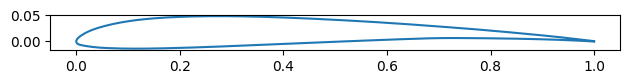

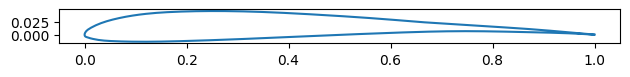

39.7686507795413 0.0048311250284314156 0.057986781334666185


In [2]:
points = 'samples/DiffusionAirfoilTransform_000.dat'
airfoil = np.loadtxt(points, skiprows=1)
show_airfoil(airfoil)
af, R, a, b, perf, cd, CD_BL = lowestD(airfoil, Re2= 400000, lamda = LAMBDA, check_thickness=False, modify_thickness = True)
show_airfoil(af)
# af = setupflap(airfoil)
# af[:,1] = af[:,1] * 0.058 / cal_thickness(af)
# cd, _ = evalpreset(af)
# perf,_,_ = evalperf(setflap(af, 2))
print(perf, CD_BL, cal_thickness(af))
# np.savetxt('samples/'+points.split('/')[1].split('.')[0]+f'_{a}_{b}F'+'.dat', af, header=points.split('/')[1].split('.')[0]+f'_{a}_{b}F', comments="")

In [28]:
cds = np.array([np.nan, np.nan, np.nan])
i_nan = np.argwhere(np.isnan(cds))
cds = np.delete(cds, i_nan)
try:
    cd = cds.max()
except:
    cd = np.nan

In [ ]:
import numpy as np
from utils import *
points = 'results/airfoilPPO.dat'
airfoil = np.loadtxt(points, skiprows=1)
af, R, a, b, perf, cd, CD_BL = lowestD(airfoil, lamda = LAMBDA)
name = points.split('/')[1].split('.')[0]+f'_{a}_{b}F'
np.savetxt(points.split('.')[0]+f'_{a}_{b}F'+'.dat', af, header=points.split('/')[1].split('.')[0]+f'_{a}_{b}F', comments="")

R, a, b, perf, cd, CD_BL

In [ ]:
show_airfoil(af)
detect_intersect(af), cal_thickness(af)

In [ ]:
points = 'samples/Airfoils1D_003.dat'
airfoil = np.loadtxt(points, skiprows=1)
af = setupflap(airfoil, theta=-2, pose=0.65)
evalpreset(af)
# af = setflap(af, theta=2, pose = 0.7)
# evalperf(af)
# show_airfoil(af)

In [ ]:
points = 'samples/Airfoils2D_009_-3.0_0.65F.dat'
airfoil = np.loadtxt(points, skiprows=1)
cal_thickness(airfoil)